# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,rebate_or_grant,expansion_system,third_party_owned,self_installed,tilt_1,additional_modules,bipv_module_1,efficiency_module_1,inverter_quantity_1,...,inverter_model_1_IQ6PLUS-72-ACM-US [240V],inverter_model_1_SE3800H-US (240V),inverter_model_1_SE9KUS [208V],inverter_model_1_IQ7XS-96-E-ACM-US [240V],inverter_model_1_SE7600H-US (240V),inverter_model_1_SPR-X22-360-E-AC [208V],inverter_model_1_SE11400H-US (240V),inverter_model_1_IQ7-60-x-ACM-US [208V],inverter_model_1_SE10000H-US (240V),inverter_model_1_SB3.8-1SP-US-40 [208V]
454572,7.680000,0.0,0,0.0,0.0,25.0,0.0,0.0,0.196319,1.0,...,0,0,0,0,0,0,0,0,0,0
1980351,11.800000,1875.0,0,0.0,0.0,18.0,0.0,0.0,0.182099,1.0,...,0,0,0,0,0,0,0,0,0,0
370974,3.150000,2201.0,0,0.0,0.0,18.0,0.0,0.0,0.214724,9.0,...,0,0,0,0,0,0,0,0,0,0
485150,3.113918,0.0,0,1.0,0.0,27.0,0.0,0.0,0.193939,5.0,...,0,0,0,0,0,0,0,0,0,0
341124,5.760000,0.0,0,0.0,0.0,23.0,0.0,0.0,0.196319,18.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train.shape, y_train.shape

((156192, 400), (156192, 1))

In [5]:
X_train.columns

Index(['system_size_dc', 'rebate_or_grant', 'expansion_system',
       'third_party_owned', 'self_installed', 'tilt_1', 'additional_modules',
       'bipv_module_1', 'efficiency_module_1', 'inverter_quantity_1',
       ...
       'inverter_model_1_IQ6PLUS-72-ACM-US [240V]',
       'inverter_model_1_SE3800H-US (240V)', 'inverter_model_1_SE9KUS [208V]',
       'inverter_model_1_IQ7XS-96-E-ACM-US [240V]',
       'inverter_model_1_SE7600H-US (240V)',
       'inverter_model_1_SPR-X22-360-E-AC [208V]',
       'inverter_model_1_SE11400H-US (240V)',
       'inverter_model_1_IQ7-60-x-ACM-US [208V]',
       'inverter_model_1_SE10000H-US (240V)',
       'inverter_model_1_SB3.8-1SP-US-40 [208V]'],
      dtype='object', length=400)

First I'm going to train a few dummy regression models to see how they performs and to set a benchmark of what I should consider a useful model. Since there isn't any reason large outliers should be extra harshly penalized, I'm going to rank the models based on mean absolute error (MAE), while plotting both MAE and root mean squared error (RMSE).

In [6]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.8)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((31238, 400), (124954, 400), (31238, 1), (124954, 1))

In [7]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

In [8]:
# Using the mean of the training set
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_tr, y_tr)
y_pred = dummy_mean.predict(x_te)
train_scores = {'Mean Dummy Regressor' : mean_squared_error(y_te, y_pred)}
print(mean_squared_error(y_te, y_pred))

55122254.790286995


In [9]:
# Using the median of the training set
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(x_tr, y_tr)
y_pred = dummy_median.predict(x_te)
train_scores['Median Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

55164857.971142314


In [10]:
# One final dummy regressor using the 25th quantile of the training set
dummy_quantile = DummyRegressor(strategy="quantile", quantile = 0.25)
dummy_quantile.fit(x_tr, y_tr)
y_pred = dummy_quantile.predict(x_te)
train_scores['25th Quantile Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

55924623.26652007


Now that I have some base RMSE values that give me a cutoff for whether my models are effective or not, I'll begin with an ordinary least squares model.

In [11]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
train_scores['OLS'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

4.0087382954495144e+16


As expected, OLS produces a big improvement over the dummy regressors. I'll take a look at ridge regression to see if it will generate a better model.

In [16]:
parameters = {'alpha': sp_randFloat(2,100)}
ridge = Ridge(random_state = 12)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 63.38753065382816}

In [17]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

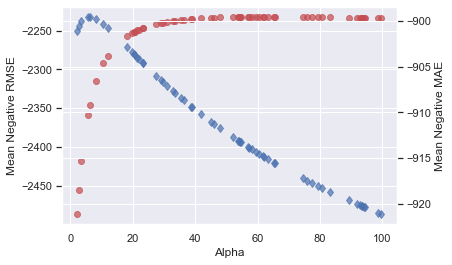

In [18]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an idea of where the optimal alpha value lies for the ridge regression I'll fit an optimized ridge to the train data and add the RMSE to my collection of scores.

In [19]:
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 12)
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

54623089.553966075


So ridge regression performs almost the exact same as OLS, good to know. Next I'll identify the best alpha for a lasso regression to compare that against the OLS and ridge models.

In [ ]:
parameters = {'alpha': sp_randFloat(1,50)}
lasso = linear_model.Lasso(random_state = 12)
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

In [ ]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
rand_lasso_params.head()

In [ ]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

In [ ]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 12)
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores['Lasso'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

Again, almost the exact same performance relative to ridge and OLS regression. Next I'm going to take a look at random forest and see if that can produce a significant reduction in MAE.

In [24]:
parameters = {'n_estimators': sp_randInt(10,1000),
             'max_features': sp_randFloat(0.01, 1),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(400,10000),
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 9,
 'max_features': 0.6943250674615364,
 'min_samples_leaf': 608,
 'n_estimators': 990}

In [25]:
rand_forest_params = pd.DataFrame(rand_forest.cv_results_)
rand_forest_params.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_n_estimators', 'params',
       'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

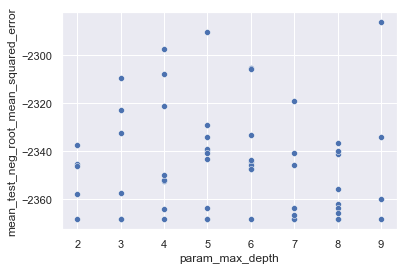

In [26]:
sns.scatterplot(data=rand_forest_params, x='param_max_depth', y='mean_test_neg_root_mean_squared_error')
plt.show()

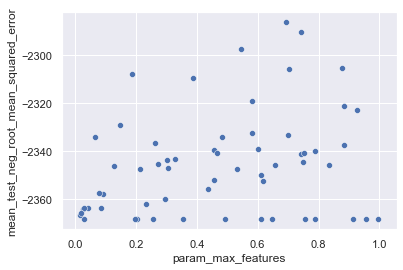

In [27]:
sns.scatterplot(data=rand_forest_params, x='param_max_features', y='mean_test_neg_root_mean_squared_error')
plt.show()

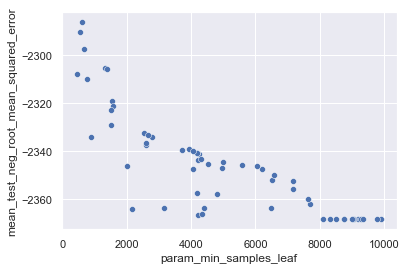

In [28]:
sns.scatterplot(data=rand_forest_params, x='param_min_samples_leaf', y='mean_test_neg_root_mean_squared_error')
plt.show()

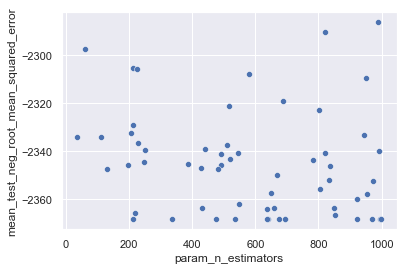

In [29]:
sns.scatterplot(data=rand_forest_params, x='param_n_estimators', y='mean_test_neg_root_mean_squared_error')
plt.show()

In [30]:
parameters = {
             'min_samples_leaf': sp_randInt(1,2000),
             'n_estimators': sp_randInt(800,1100)
             }
forest = RandomForestRegressor(max_features=rand_forest.best_params_['max_features'],\
                               max_depth=rand_forest.best_params_['max_depth'], n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
random_forest = forest_reg.fit(x_tr, y_tr)
random_forest.best_params_

{'min_samples_leaf': 50, 'n_estimators': 941}

In [31]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=random_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores['Random Forest'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

54529920.36273953

Nice, random forest improved upon the other models very significantly. I'll take a look at XGBoost next to see if it can improve even further.

In [34]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster = rand_xgb.fit(x_tr, y_tr)
xgbooster.best_params_

ValueError: feature_names must be string, and may not contain [, ] or <

In [ ]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

Wow! XGBoost knocked down the MAE from 680 (with random forest) to 72! Just for some context I'm going to check the range between the 5th and 95th percentiles of the price per KW just to get an idea of how much error \\$72 represents.

In [ ]:
print(np.quantile(y_train['price_per_kw'], 0.05))
print(np.quantile(y_train['price_per_kw'], 0.95))

Great! 90% of the data lie within a \\$4100 spread, so having an estimate with \\$72 error is pretty good. Let's see if we can get any better with a decision tree.

In [ ]:
d_tree = tree.DecisionTreeRegressor(random_state = 12)
parameters = {'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
decision_tree = rand_tree.fit(x_tr, y_tr)
decision_tree.best_params_

In [ ]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 12)
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores['Decision Tree'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

Interesting, even a basic decision tree outperformed the random forest and lasso regressors. Let's keep testing a few additional models to determine which should be tuned further and used as the final model.

In [ ]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_nn = rand_knn.fit(x_tr, y_tr)
opt_nn.best_params_

In [ ]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

In [ ]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lgbm = rand_lgbm.fit(x_tr, y_tr)
opt_lgbm.best_params_

In [ ]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes = (89, 89, 89), random_state = 12)
parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
             'solver': ['lbfgs', 'sgd', 'adam'],
             'max_iter': sp_randInt(500,1000)}
rand_mlp = RandomizedSearchCV(mlp, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_mlp = rand_mlp.fit(x_tr, y_tr)
opt_mlp.best_params_

In [ ]:
mlp_opt = MLPRegressor(random_state = 12)
mlp_opt.fit(x_tr, y_tr)
y_pred = mlp_opt.predict(x_te)
train_scores['MLP'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

In [ ]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Absolute Error')
plt.title('Model Accuracy Comparison')
plt.show()

Now that I've done a quick once-over for these different models and identified XGBoost as the best fit for this challenge, I'm going to revisit XGBoost and see if I can't refine it further to improve the results even more.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 14))
xgboost.plot_importance(xgb_model, ax=ax)

In [ ]:
# Previous best parameters
# 'colsample_bytree': 0.9887415865233958,
# 'eta': 0.3412489908771189,
# 'max_depth': 9,
# 'n_estimators': 859

xgb_2 = XGBRegressor(verbosity = 0)
parameters = {'n_estimators': sp_randInt(759,959),
             'max_depth': sp_randInt(7,11),
             'eta': sp_randFloat(0.14,0.54),
             'colsample_bytree': sp_randFloat(0.9,1)} 
rand_xgb_2 = RandomizedSearchCV(xgb_2, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_2 = rand_xgb_2.fit(x_tr, y_tr)
xgbooster_2.best_params_

In [ ]:
xgb_model_2 = XGBRegressor(n_estimators=xgbooster_2.best_params_['n_estimators'],\
                                   eta=xgbooster_2.best_params_['eta'],\
                                   colsample_bytree=xgbooster_2.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster_2.best_params_['max_depth'])
xgb_model_2.fit(x_tr, y_tr)
y_pred = xgb_model_2.predict(x_te)
train_scores['XGBoost 2'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 14))
xgboost.plot_importance(xgb_model_2, ax=ax)

In [ ]:
xgb_linear = XGBRegressor(booster = 'gblinear', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['cyclic', 'shuffle']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

In [ ]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

In [ ]:
xgb_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

In [ ]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)